In [5]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

Đã tải mô hình thành công!
Các quận hiện có trong mô hình: ['Huyện Hòa Vang', 'Quận Cẩm Lệ', 'Quận Hải Châu', 'Quận Liên Chiểu', 'Quận Ngũ Hành Sơn', 'Quận Sơn Trà', 'Quận Thanh Khê']
Đang dự báo giá cho Huyện Hòa Vang từ 2025-04-09 đến 2026-04-09...

Kết quả dự báo:
        Ngày            Quận  Giá dự báo (đơn vị/m2)
0 2025-04-09  Huyện Hòa Vang               -1.439598
1 2025-04-10  Huyện Hòa Vang               -1.450050
2 2025-04-11  Huyện Hòa Vang               -1.450785
3 2025-04-12  Huyện Hòa Vang               -1.451951
4 2025-04-13  Huyện Hòa Vang               -1.452466
5 2025-04-14  Huyện Hòa Vang               -1.444470
6 2025-04-15  Huyện Hòa Vang               -1.448628
7 2025-04-16  Huyện Hòa Vang               -1.448972
8 2025-04-17  Huyện Hòa Vang               -1.449717
9 2025-04-18  Huyện Hòa Vang               -1.450452

Đã lưu kết quả dự báo vào file: Huyện Hòa Vang_forecast_2025-04-09_to_2026-04-09.csv


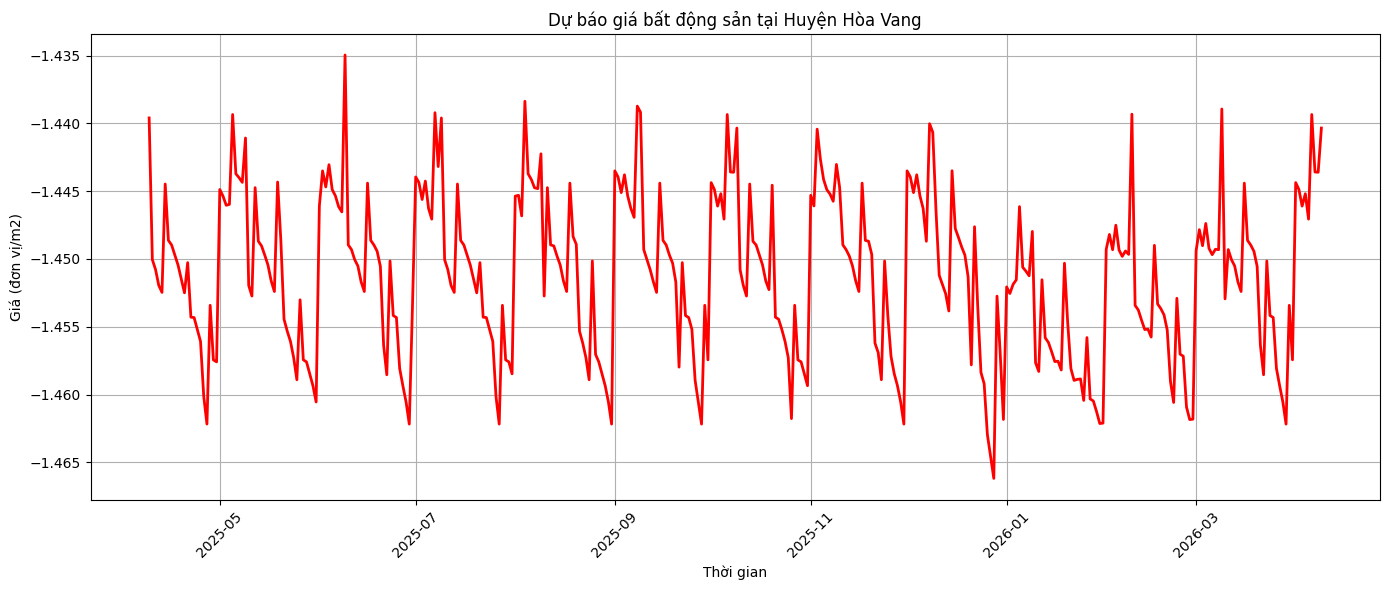

In [6]:
# Hàm tạo các đặc trưng thời gian
def create_time_features(df):
    """
    Tạo các đặc trưng thời gian cho mô hình XGBoost
    
    Parameters:
    df (DataFrame): DataFrame gốc
    
    Returns:
    DataFrame: DataFrame với các đặc trưng thời gian mới
    """
    df_copy = df.copy()
    
    # Trích xuất các thành phần thời gian
    df_copy['year'] = df_copy['Posted Time'].dt.year
    df_copy['month'] = df_copy['Posted Time'].dt.month
    df_copy['day'] = df_copy['Posted Time'].dt.day
    df_copy['dayofweek'] = df_copy['Posted Time'].dt.dayofweek
    df_copy['quarter'] = df_copy['Posted Time'].dt.quarter
    
    # Tạo đặc trưng ngày của năm
    df_copy['dayofyear'] = df_copy['Posted Time'].dt.dayofyear
    
    # Tạo biến chỉ báo cho các ngày cuối tuần
    df_copy['is_weekend'] = df_copy['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)
    
    # Biến chỉ báo theo mùa (tùy chỉnh theo ngữ cảnh Việt Nam)
    # Mùa xuân (tháng 1-3), Mùa hè (tháng 4-6), Mùa thu (tháng 7-9), Mùa đông (tháng 10-12)
    season_dict = {1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 2, 8: 2, 9: 2, 10: 3, 11: 3, 12: 3}
    df_copy['season'] = df_copy['month'].map(season_dict)
    
    # Tính thời gian trôi qua từ ngày đầu tiên trong dữ liệu
    min_date = pd.to_datetime('2024-01-01')  # Giả định một ngày làm mốc
    df_copy['days_from_min'] = (df_copy['Posted Time'] - min_date).dt.days
    
    # Tạo các biến sin và cos của tháng để nắm bắt tính chu kỳ
    df_copy['month_sin'] = np.sin(2 * np.pi * df_copy['month'] / 12)
    df_copy['month_cos'] = np.cos(2 * np.pi * df_copy['month'] / 12)
    
    return df_copy

# Hàm tạo đặc trưng lag và rolling
def create_lag_features(district_df, lag_days=[7, 14, 30], window_sizes=[7, 14, 30]):
    """
    Tạo các đặc trưng lag và rolling
    """
    df_copy = district_df.copy()
    
    # Điền các giá trị cho các đặc trưng lag và rolling
    # Trong trường hợp dự báo tương lai, ta sẽ tự tạo giá trị
    for lag in lag_days:
        df_copy[f'price_lag_{lag}'] = 0
    
    for window in window_sizes:
        df_copy[f'price_rolling_mean_{window}'] = 0
        df_copy[f'price_rolling_std_{window}'] = 0
    
    df_copy['price_diff_1'] = 0
    df_copy['price_diff_7'] = 0
    df_copy['price_pct_change_1'] = 0
    df_copy['price_pct_change_7'] = 0
    
    return df_copy

# Hàm dự báo cho tương lai
def forecast_future_prices(district_name, model_info, start_date, end_date):
    """
    Dự báo giá bất động sản cho một quận từ ngày bắt đầu đến ngày kết thúc
    
    Parameters:
    district_name (str): Tên quận cần dự báo
    model_info (dict): Thông tin về mô hình của quận
    start_date (str): Ngày bắt đầu dự báo (YYYY-MM-DD)
    end_date (str): Ngày kết thúc dự báo (YYYY-MM-DD)
    
    Returns:
    DataFrame: Kết quả dự báo
    """
    # Lấy thông tin mô hình
    model = model_info['model']
    feature_columns = model_info['feature_columns']
    
    # Tạo các ngày cần dự báo
    future_dates = pd.date_range(start=start_date, end=end_date)
    future_df = pd.DataFrame({'Posted Time': future_dates})
    future_df['District Name'] = district_name
    
    # Tạo các đặc trưng thời gian
    future_df = create_time_features(future_df)
    
    # Tạo các đặc trưng lag và rolling
    future_df = create_lag_features(future_df)
    
    # Chuẩn bị dữ liệu cho dự báo
    X_future = future_df[feature_columns]
    
    # Dự báo
    predictions = model.predict(X_future)
    
    # Tạo DataFrame kết quả
    result_df = pd.DataFrame({
        'Ngày': future_dates,
        'Quận': district_name,
        'Giá dự báo (đơn vị/m2)': predictions
    })
    
    return result_df

# Hàm vẽ biểu đồ dự báo
def plot_forecast(forecast_df, district_name):
    """
    Vẽ biểu đồ dự báo giá
    
    Parameters:
    forecast_df (DataFrame): Kết quả dự báo
    district_name (str): Tên quận
    """
    plt.figure(figsize=(14, 6))
    
    plt.plot(forecast_df['Ngày'], forecast_df['Giá dự báo (đơn vị/m2)'], 'r-', linewidth=2)
    
    plt.title(f'Dự báo giá bất động sản tại {district_name}')
    plt.xlabel('Thời gian')
    plt.ylabel('Giá (đơn vị/m2)')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Chương trình chính
def main():
    # Đọc model từ file
    try:
        with open('district_xgboost_models.pkl', 'rb') as f:
            district_models = pickle.load(f)
        print("Đã tải mô hình thành công!")
    except Exception as e:
        print(f"Lỗi khi tải mô hình: {e}")
        return
    
    # Danh sách các quận có trong mô hình
    available_districts = list(district_models.keys())
    print(f"Các quận hiện có trong mô hình: {available_districts}")
    
    # Chọn quận để dự báo
    district_name = available_districts[0]  # Thay đổi đây để chọn quận khác
    
    # Thời gian dự báo (3 tháng tới)
    today = datetime.now()
    start_date = today.strftime('%Y-%m-%d')
    end_date = (today + timedelta(days=365)).strftime('%Y-%m-%d')
    
    print(f"Đang dự báo giá cho {district_name} từ {start_date} đến {end_date}...")
    
    # Dự báo
    forecast_result = forecast_future_prices(
        district_name,
        district_models[district_name],
        start_date,
        end_date
    )
    
    # Hiển thị kết quả
    print("\nKết quả dự báo:")
    print(forecast_result.head(10))  # Hiển thị 10 ngày đầu tiên
    
    # Xuất kết quả ra file CSV
    csv_filename = f"{district_name}_forecast_{start_date}_to_{end_date}.csv"
    forecast_result.to_csv(csv_filename, index=False)
    print(f"\nĐã lưu kết quả dự báo vào file: {csv_filename}")
    
    # Vẽ biểu đồ
    plot_forecast(forecast_result, district_name)

if __name__ == "__main__":
    main()